In [ ]:
from google.colab import files
files.upload()  # Upload the kaggle.json file

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"amarhamouma","key":"3c2351ea67223cf466bcfac2419b0568"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # Set permissions

In [ ]:
!kaggle datasets download -d sakshaymahna/cityscapes-depth-and-segmentation

Dataset URL: https://www.kaggle.com/datasets/sakshaymahna/cityscapes-depth-and-segmentation
License(s): other
100% 642M/642M [00:29<00:00, 24.0MB/s]
100% 642M/642M [00:29<00:00, 22.9MB/s]


In [ ]:
!unzip cityscapes-depth-and-segmentation.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/train/image/526.npy  
  inflating: data/train/image/527.npy  
  inflating: data/train/image/528.npy  
  inflating: data/train/image/529.npy  
  inflating: data/train/image/53.npy  
  inflating: data/train/image/530.npy  
  inflating: data/train/image/531.npy  
  inflating: data/train/image/532.npy  
  inflating: data/train/image/533.npy  
  inflating: data/train/image/534.npy  
  inflating: data/train/image/535.npy  
  inflating: data/train/image/536.npy  
  inflating: data/train/image/537.npy  
  inflating: data/train/image/538.npy  
  inflating: data/train/image/539.npy  
  inflating: data/train/image/54.npy  
  inflating: data/train/image/540.npy  
  inflating: data/train/image/541.npy  
  inflating: data/train/image/542.npy  
  inflating: data/train/image/543.npy  
  inflating: data/train/image/544.npy  
  inflating: data/train/image/545.npy  
  inflating: data/train/image/546.npy  
  inflating: data/train/image/5

In [ ]:
!pip install torchmetrics
!pip install torchvision
!pip install pytorch_lightning

In [ ]:
import os
import torch
import cv2

import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt

from PIL import Image
from torchvision.transforms import Normalize
from torchsummary import summary
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from skimage.transform import resize

## Shapes of input data - visualization

Shape of the image array: (128, 256, 3)
Data type of the image array: float64


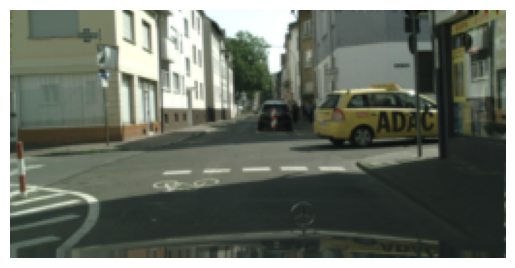

In [ ]:
import numpy as np

# Load the .npy file
image_array = np.load("./data/val/image/0.npy")

# Check the shape and data type of the array
print("Shape of the image array:", image_array.shape)
print("Data type of the image array:", image_array.dtype)

# Display the image
plt.imshow(image_array)  # Use cmap="gray" for grayscale images
plt.axis("off")  # Hide axes
plt.show()

## Number of val and train images

Number of train RGB images : 2975
Number of train depth maps: 2975
Number of train labels: 2975
Number of val RGB images : 500
Number of val depth maps: 500
Number of val labels: 500


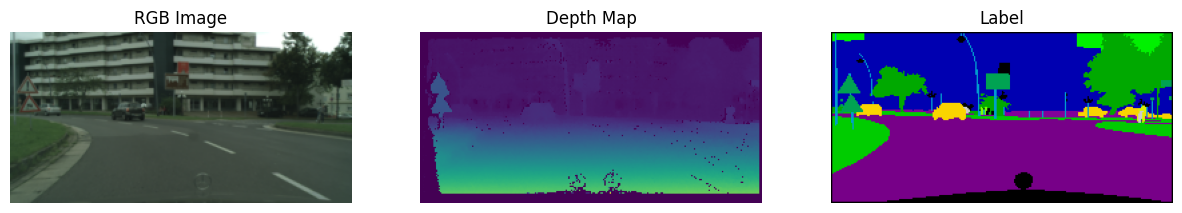

In [ ]:
# Path to the dataset
dataset_path_train = "data/train"
dataset_path_val = "data/val"

# List files in the images, depth, and label folders
image_files_train = sorted(os.listdir(os.path.join(dataset_path_train, "image")))
depth_files_train = sorted(os.listdir(os.path.join(dataset_path_train, "depth")))
label_files_train = sorted(os.listdir(os.path.join(dataset_path_train, "label")))

image_files_val = sorted(os.listdir(os.path.join(dataset_path_val, "image")))
depth_files_val = sorted(os.listdir(os.path.join(dataset_path_val, "depth")))
label_files_val = sorted(os.listdir(os.path.join(dataset_path_val, "label")))

# Check the number of files
print(f"Number of train RGB images : {len(image_files_train)}")
print(f"Number of train depth maps: {len(depth_files_train)}")
print(f"Number of train labels: {len(label_files_train)}")

print(f"Number of val RGB images : {len(image_files_val)}")
print(f"Number of val depth maps: {len(depth_files_val)}")
print(f"Number of val labels: {len(label_files_val)}")

# Load the first RGB image, depth map, and label
image_path = os.path.join(dataset_path_train, "image", image_files_train[0])
depth_path = os.path.join(dataset_path_train, "depth", depth_files_train[0])
label_path = os.path.join(dataset_path_train, "label", label_files_train[0])

image = np.load(image_path)
depth = np.load(depth_path)
label = np.load(label_path)

# Display the RGB image, depth map, and label
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("RGB Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(depth, cmap="viridis")  # Use a colormap for depth visualization
plt.title("Depth Map")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(label, cmap="nipy_spectral")  # Use a colormap for label visualization
plt.title("Label")
plt.axis("off")

plt.show()

## Computing Nan, inf, zeros, min, max and mean values

In [ ]:
print("************ Depth map example ************")
depth_map = np.load("data/train/depth/1.npy")
print("Number of NaN values:", np.isnan(depth_map).sum())
print("Number of inf values:", np.isinf(depth_map).sum())
print("Number of zero values:", (depth_map == 0).sum())
print("Number of non zero values:", (depth_map != 0).sum())
print("max", np.max(depth_map))
print("min", np.min(depth_map))
print("mean", np.mean(depth_map))

print("\n")

print("************ RGB image example ************")
rgb = np.load("data/train/image/100.npy")
print("Number of NaN values:", np.isnan(rgb).sum())
print("Number of inf values:", np.isinf(rgb).sum())
print("Number of zero values:", (rgb == 0).sum())
print("Number of non zero values:", (rgb != 0).sum())
print("max", np.max(rgb))
print("min", np.min(rgb))
print("mean", np.mean(rgb))

************ Depth map example ************
Number of NaN values: 0
Number of inf values: 0
Number of zero values: 4557
Number of non zero values: 28211
max 0.43317312002182007
min 0.0
mean 0.09575011004647394


************ RGB image example ************
Number of NaN values: 0
Number of inf values: 0
Number of zero values: 0
Number of non zero values: 98304
max 0.8117647058823529
min 0.043137254901960784
mean 0.2561216267105801


## Create Dataset

In [ ]:
class NYUDepthV2Dataset(Dataset):
    def __init__(self, image_dir, depth_dir, image_transform=None, depth_transform=None):
        self.image_dir = image_dir
        self.depth_dir = depth_dir
        self.image_transform = image_transform
        self.depth_transform = depth_transform
        self.image_files = sorted(os.listdir(image_dir))
        self.depth_files = sorted(os.listdir(depth_dir))

    def __len__(self):
        return len(self.image_files)


    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_files[idx])
        depth_path = os.path.join(self.depth_dir, self.depth_files[idx])

        # Load RGB image and depth map
        image_np = np.load(image_path)  # Shape: (H, W, 3)
        depth_np = np.load(depth_path)  # Shape: (H, W)

        resized_image = cv2.resize(image_np, (384, 384), interpolation=cv2.INTER_LINEAR)
        resized_depth = cv2.resize(depth_np, (384, 384), interpolation=cv2.INTER_LINEAR)

        # Convert numpy arrays to PyTorch tensors
        image_tensor = torch.from_numpy(resized_image).permute(2, 0, 1).float()
        depth_tensor = torch.from_numpy(resized_depth).unsqueeze(0).float()

        return image_tensor, depth_tensor

## Create DataLoaders

In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data import Subset
import random

# Create dataset
train_dataset = NYUDepthV2Dataset(
    image_dir="data/train/image",
    depth_dir="data/train/depth",
)


# Get the total number of items in the dataset
total_items = len(train_dataset)

# Generate a list of indices for the entire dataset
indices = list(range(total_items))

# Shuffle the indices randomly
random.shuffle(indices)

# Select 300 indices for the test dataset
test_indices = indices[:300]

# Select the remaining indices for the train dataset
train_indices = indices[300:]

# Create the test dataset from the selected indices
test_dataset = Subset(train_dataset, test_indices)

# Create the train dataset from the remaining indices
train_dataset = Subset(train_dataset, train_indices)


val_dataset = NYUDepthV2Dataset(
    image_dir="data/val/image",
    depth_dir="data/val/depth",
)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2)

In [ ]:
print(f"number of elements in the train_dataset is: {len(train_dataset)}")
print(f"number of elements in the val_dataset is: {len(val_dataset)}")
print(f"number of elements in the test_dataset is: {len(test_dataset)}")

number of elements in the train_dataset is: 2675
number of elements in the val_dataset is: 500
number of elements in the test_dataset is: 300


## Checking the shapes

In [ ]:
# Check a sample from the dataset
rgb, depth_map = train_dataset[110]
print("Image shape:", rgb.shape)  # Should be (3, H, W)
print("Depth shape:", depth_map.shape)  # Should be (1, H, W)

Image shape: torch.Size([3, 384, 384])
Depth shape: torch.Size([1, 384, 384])


## Loading the model: DPT_Hybrid

In [ ]:
model = torch.hub.load("intel-isl/MiDaS", "DPT_Hybrid")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
summary(model, input_size=(3, 384, 384))

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
     StdConv2dSame-1         [-1, 64, 192, 192]           9,408
          Identity-2         [-1, 64, 192, 192]               0
              ReLU-3         [-1, 64, 192, 192]               0
      GroupNormAct-4         [-1, 64, 192, 192]             128
     MaxPool2dSame-5           [-1, 64, 96, 96]               0
     StdConv2dSame-6          [-1, 256, 96, 96]          16,384
          Identity-7          [-1, 256, 96, 96]               0
          Identity-8          [-1, 256, 96, 96]               0
      GroupNormAct-9          [-1, 256, 96, 96]             512
   DownsampleConv-10          [-1, 256, 96, 96]               0
    StdConv2dSame-11           [-1, 64, 96, 96]           4,096
         Identity-12           [-1, 64, 96, 96]               0
             ReLU-13           [-1, 64, 96, 96]               0
     GroupNormAct-14           [-1, 64,

## MiDaSFineTuner - Class

In [ ]:
def visualize_prediction(inputs, outputs, targets):
    """
    Visualizes the input image, predicted depth map, and ground truth depth map.
    Handles tensors with a batch dimension.
    """
    # Remove the batch dimension
    inputs = inputs[0]  # Take the first image in the batch
    outputs = outputs[0].squeeze(0)  # Take the first prediction, remove the channel dimension
    targets = targets[0].squeeze(0)  # Take the first ground truth, remove the channel dimension

    # Plot the images
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    # Display the input image
    axs[0].imshow(inputs.permute(1, 2, 0).cpu().numpy())  # Assume input is in [0, 255]
    axs[0].set_title("Input RGB")
    axs[0].axis("off")

    # Display the predicted depth map
    axs[1].imshow(outputs.cpu().numpy(), cmap="inferno")
    axs[1].set_title("Predicted Depth")
    axs[1].axis("off")

    # Display the ground truth depth map
    axs[2].imshow(targets.cpu().numpy(), cmap="inferno")
    axs[2].set_title("Ground Truth Depth")
    axs[2].axis("off")

    plt.show()

In [ ]:
import pytorch_lightning as pl
import torch.optim as optim
import torchmetrics
from torchmetrics.image import StructuralSimilarityIndexMeasure
import torch.nn as nn

class MiDaSFineTuner(pl.LightningModule):
    def __init__(self, learning_rate=5e-5):
        super().__init__()
        self.model = torch.hub.load("intel-isl/MiDaS", "DPT_Hybrid")
        self.learning_rate = learning_rate
        self.loss_fn = nn.L1Loss()


        self.train_ssi = StructuralSimilarityIndexMeasure(data_range=1.0)
        self.val_ssi = StructuralSimilarityIndexMeasure(data_range=1.0)
        self.test_ssi = StructuralSimilarityIndexMeasure(data_range=1.0)

        for param in self.model.parameters():
          param.requires_grad = True

        for param in self.model.scratch.output_conv.parameters():
          param.requires_grad = True

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch


        y_hat = self(x)
        y_hat = (y_hat - y_hat.min()) / (y_hat.max() - y_hat.min())

        y_hat = y_hat.unsqueeze(1)

        #print(y)

        loss = self.loss_fn(y_hat, y)

        train_ssi = self.train_ssi(y_hat, y)

        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log("train_ssi", train_ssi, on_step=False, on_epoch=True, prog_bar=True, logger=True)

        return loss

    def on_train_epoch_end(self):
        self.train_ssi.reset()

    def validation_step(self, batch, batch_idx):
        x, y = batch

        y_hat = self(x)
        y_hat = (y_hat - y_hat.min()) / (y_hat.max() - y_hat.min())

        y_hat = y_hat.unsqueeze(1)

        #visualize_prediction(x, y_hat, y)

        loss = self.loss_fn(y_hat, y)
        val_ssi = self.val_ssi(y_hat, y)

        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_ssi", val_ssi, on_step=False, on_epoch=True, prog_bar=True, logger=True)

        return loss

    def on_validation_epoch_end(self):
        self.val_ssi.reset()


    def test_step(self, batch, batch_idx):
        x, y = batch

        y_hat = self(x)
        y_hat = (y_hat - y_hat.min()) / (y_hat.max() - y_hat.min())

        y_hat = y_hat.unsqueeze(1)

        #visualize_prediction(x, y_hat, y)

        loss = self.loss_fn(y_hat, y)
        test_ssi = self.test_ssi(y_hat, y)

        self.log("test_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("test_ssi", test_ssi, on_step=False, on_epoch=True, prog_bar=True, logger=True)

        return loss

    def on_test_epoch_end(self):
        self.test_ssi.reset()

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

## Trainer + Train

In [ ]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor

# Initialize the model and trainer
model_ = MiDaSFineTuner()

checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='checkpoints',
    filename='best-checkpoint-2',
    save_top_k=1,
    mode='min'
)

early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=3,
    mode='min'
)

trainer = Trainer(max_epochs=15,
                  accelerator="gpu" if torch.cuda.is_available() else "cpu",  # Use GPU if available
                  devices=1,  # Number of GPUs or CPUs
                  log_every_n_steps=1,
                  callbacks = [checkpoint_callback, early_stop_callback]
                  )

# Start training
trainer.fit(model_, train_loader, val_loader)

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
/usr/local/lib/python3.11/dist-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name vit_base_resnet50_384 to current vit_base_r50_s16_384.orig_in21k_ft_in1k.
  model = create_fn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                             | Params | Mode 
-----------------------------------------------------------------------
0 | model     | DPTDepthModel                    | 1

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


## Testing

In [ ]:
trainer.test(dataloaders=test_loader, ckpt_path="checkpoints/best-checkpoint-2.ckpt")

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at checkpoints/best-checkpoint-2.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at checkpoints/best-checkpoint-2.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   0.014726735651493073    │
│         test_ssi          │    0.8764961957931519     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.014726735651493073, 'test_ssi': 0.8764961957931519}]

## Testing on some images (in the test dataset)

In [ ]:
model_load = MiDaSFineTuner.load_from_checkpoint("checkpoints/best-checkpoint-2.ckpt")

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
/usr/local/lib/python3.11/dist-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name vit_base_resnet50_384 to current vit_base_r50_s16_384.orig_in21k_ft_in1k.
  model = create_fn(


In [ ]:
model_load.eval()

MiDaSFineTuner(
  (model): DPTDepthModel(
    (pretrained): Module(
      (model): VisionTransformer(
        (patch_embed): HybridEmbed(
          (backbone): ResNetV2(
            (stem): Sequential(
              (conv): StdConv2dSame(3, 64, kernel_size=(7, 7), stride=(2, 2), bias=False)
              (norm): GroupNormAct(
                32, 64, eps=1e-05, affine=True
                (drop): Identity()
                (act): ReLU(inplace=True)
              )
              (pool): MaxPool2dSame(kernel_size=(3, 3), stride=(2, 2), padding=(0, 0), dilation=(1, 1), ceil_mode=False)
            )
            (stages): Sequential(
              (0): ResNetStage(
                (blocks): Sequential(
                  (0): Bottleneck(
                    (downsample): DownsampleConv(
                      (conv): StdConv2dSame(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                      (norm): GroupNormAct(
                        32, 256, eps=1e-05, affine=True
        

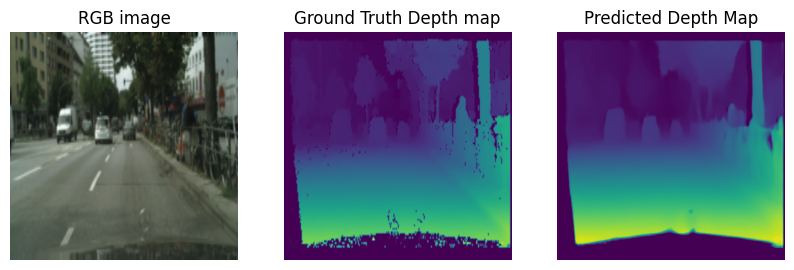

In [ ]:
def denormalize(image):
    # Denormalize the image
    if isinstance(image, torch.Tensor):
        image = image.cpu().numpy()  # Convert to NumPy array
    image = image.transpose(1, 2, 0)  # Change from (C, H, W) to (H, W, C)
    return image

def visualizer(rgb_image, depth_image, depth_map):
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))  # Create a subplot with 1 row and 2 columns

    axes[0].imshow(rgb_image)
    axes[0].set_title("RGB image")
    axes[0].axis("off")

    # Display the RGB image
    axes[1].imshow(depth_image, cmap="viridis")
    axes[1].set_title("Ground Truth Depth map")
    axes[1].axis("off")

    # Display the depth map
    axes[2].imshow(depth_map, cmap="viridis")
    axes[2].set_title("Predicted Depth Map")
    axes[2].axis("off")

    plt.show()


def predict(img):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    img = img.to(device)  # Move input tensor to the correct device
    model_load.to(device)  # Ensure the model is on the correct device

    with torch.no_grad():  # Disable gradient calculation
        output = model_load(img)

    depth_map = output.squeeze().cpu().numpy()  # Remove batch dimension and convert to numpy array
    return depth_map


image, depth = next(iter(test_loader))  # Get a batch of images and depths
rgb_image = denormalize(image[5])  # Denormalize image in the batch
depth_image = denormalize(depth[5]) #  Denormalize depth map in the batch
depth_map = predict(image)  # Predict depth map for the batch
visualizer(rgb_image, depth_image, depth_map[5])  # Visualize RGB-GT-Predicted